# Scenario F - Dataset Real (Tablets NIR)

In this scenario the the probabilistic model is tested on real-world datasets. The model parameters differ per dataset, and are set by the user. The probabilistic model is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot f_{pseudo-Voigt}(x)\big] + a_0 + a_1 \cdot x + \epsilon
\end{equation}

where:

\begin{equation}
\large f_{pseudo-Voigt}(x) = \eta \cdot \frac{\sigma_m^2}{(x-\mu_m)^2 + \sigma_m^2} + (1 - \eta) \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf
from data import Data

## Local configuration

In [3]:
# output for results and images
out_path      = './output_data_real_tablets'
file_basename = out_path + '/scenario_data_real_tablets'
        
conf = {}
    
# scenario name
conf['scenario'] = 'dataset real'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors) (normal/lognormal/eta_rv)
conf['prior_model'] = 'normal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'eval'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'dataset real',
 'init_mode': 'adapt_diag',
 'prior_model': 'normal',
 'peak_info': 'yes',
 'model_mode': 'eval',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Import data and plot

In [6]:
# dataset filelocation
dataset_filename = '../../../data/tablets/NIR_tablets.csv'

# dataset object init
data_obj = Data(dataset_filename, shuffle='yes')
data_obj.data.head(5)

,7398.337,7406.051,7413.766,7421.481,7429.195,7436.91,7444.624,7452.339,7460.053,7467.768,...,10461.02,10468.73,10476.45,10484.16,10491.88,10499.59,10507.3,content (% w/w),label,scale
231,2.243466,2.157550,2.086394,2.017384,1.949948,1.892748,1.840958,1.792403,1.747108,1.703740,...,0.417271,0.415575,0.418128,0.417318,0.410102,0.405050,0.407948,8.310028,4,0
152,1.934317,1.864531,1.796240,1.729597,1.667664,1.612752,1.562841,1.514868,1.470249,1.429754,...,0.184306,0.182690,0.184070,0.182173,0.175036,0.170698,0.173008,8.109504,3,0
88,0.794028,0.743185,0.693686,0.645892,0.601645,0.561206,0.524285,0.490702,0.459440,0.429732,...,-0.402563,-0.403531,-0.402506,-0.403968,-0.408697,-0.411159,-0.409217,6.995231,2,0
9,1.583093,1.515095,1.451080,1.388981,1.330715,1.277480,1.229091,1.184784,1.143174,1.104095,...,0.024254,0.023456,0.024929,0.023138,0.017037,0.013706,0.015856,4.715084,1,0
299,2.542833,2.451869,2.368471,2.294170,2.231056,2.170843,2.111120,2.060087,2.018312,1.975402,...,0.655893,0.653206,0.656715,0.654640,0.645328,0.641802,0.645060,8.481966,4,2


In [7]:
# select single class for inference
sclass = 1
df_cls = data_obj.data.loc[(data_obj.data['label'] == sclass)]

In [8]:
# drop non-data columns
df = df_cls.drop(columns=['label','scale','content (% w/w)'])

In [9]:
print("total number of spectra      : {0}".format(len(data_obj.data)))
print("total number of x-values     : {0}".format(len(np.array(df.columns.to_list(), dtype='float32'))))
print("total number of classes      : {0}".format(data_obj.classes))
print("selected class for inference : {0}".format(sclass))
print("number of selected spectra   : {0}".format(len(df)))
print("\nclass distribution:")
print(data_obj.data[data_obj.label_column].value_counts())

total number of spectra      : 310
total number of x-values     : 404
total number of classes      : 4
selected class for inference : 1
number of selected spectra   : 70

class distribution:
4    80
3    80
2    80
1    70
Name: label, dtype: int64


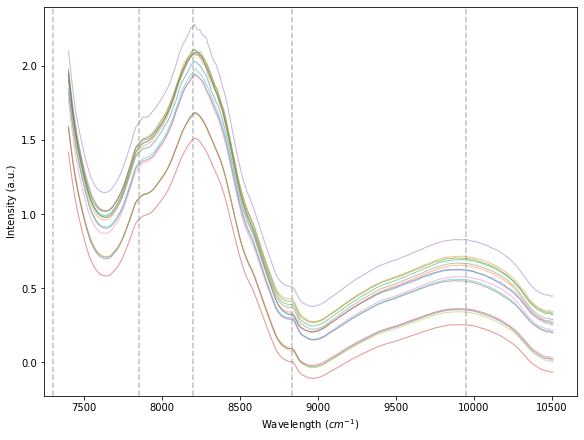

In [10]:
# number of samples to run inference on
nsamples = 15

# set peak information for spectrum
peaks = [7300.0, 7850.0, 8200.0, 8830.0, 9950.0]

# baseline profile
base_shape = 'offset'

# plot dataset (nsamples spectra, classes mixed)
fig.plot_datasets_real(df, peaks, nsamples, savefig='yes', fname=file_basename)

# Initialize models and run inference

In [11]:
ldata  = []
lpeaks = []

# add dataframes and peakinfo to list (for multiple classes or data per class)
ldata.append(df)
lpeaks.append(peaks)

In [12]:
# convert pandas data to numpy arrays
x_val = np.array(df.columns, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values[:nsamples] for i in range(len(ldata))]

In [13]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if conf['peak_info'] == 'yes':
        plist = np.array(lpeaks[0], dtype='float32').flatten()
        plist.sort()
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=len(peaks),
                              mu_peaks=plist, pmodel=conf['prior_model'], baseline=base_shape)
    else:
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=len(peaks),
                                              pmodel=conf['prior_model'], baseline=base_shape)
                
    models.append(model_g)

    with model_g:
        if conf['model_mode'] == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

loading dataset #1/1


# Model visualization

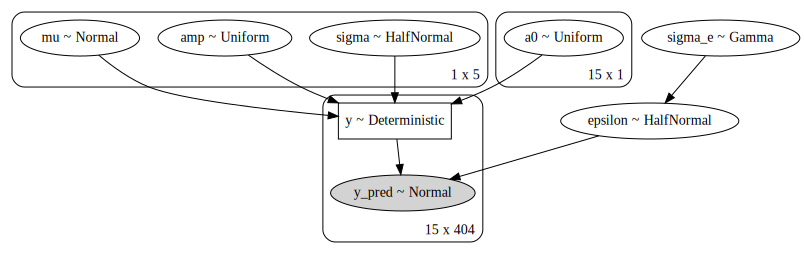

In [14]:
# display first model
pm.model_to_graphviz(models[0])

In [15]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [16]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:34<00:00, 14.44it/s]


In [17]:
# various plots to inspect the inference results
varnames = mdl.get_varnames(traces[0])
#az.summary(traces[1], varnames)

In [18]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, varnames)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
df

,r_hat,mcse,ess,bfmi,r2,waic,epsilon
1,1.457097,15.672419,19.967742,0.485896,0.987058,-16487.937439,0.062277


In [19]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

In [20]:
cnf.close(out_path)

# Plot posterior (single dataset)

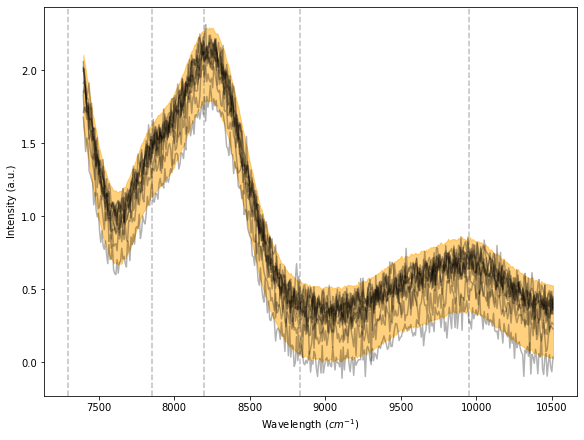

In [25]:
# dataset to plot
n_dataset = 0

# trace number in matrix
n_trace = 0

#fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 10, 
#                            file_basename, hpd_color='yellow', peak_pos=peaks)
fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 10, 
                             file_basename, hpd_color='orange', peak_pos=peaks, no_data='yes')

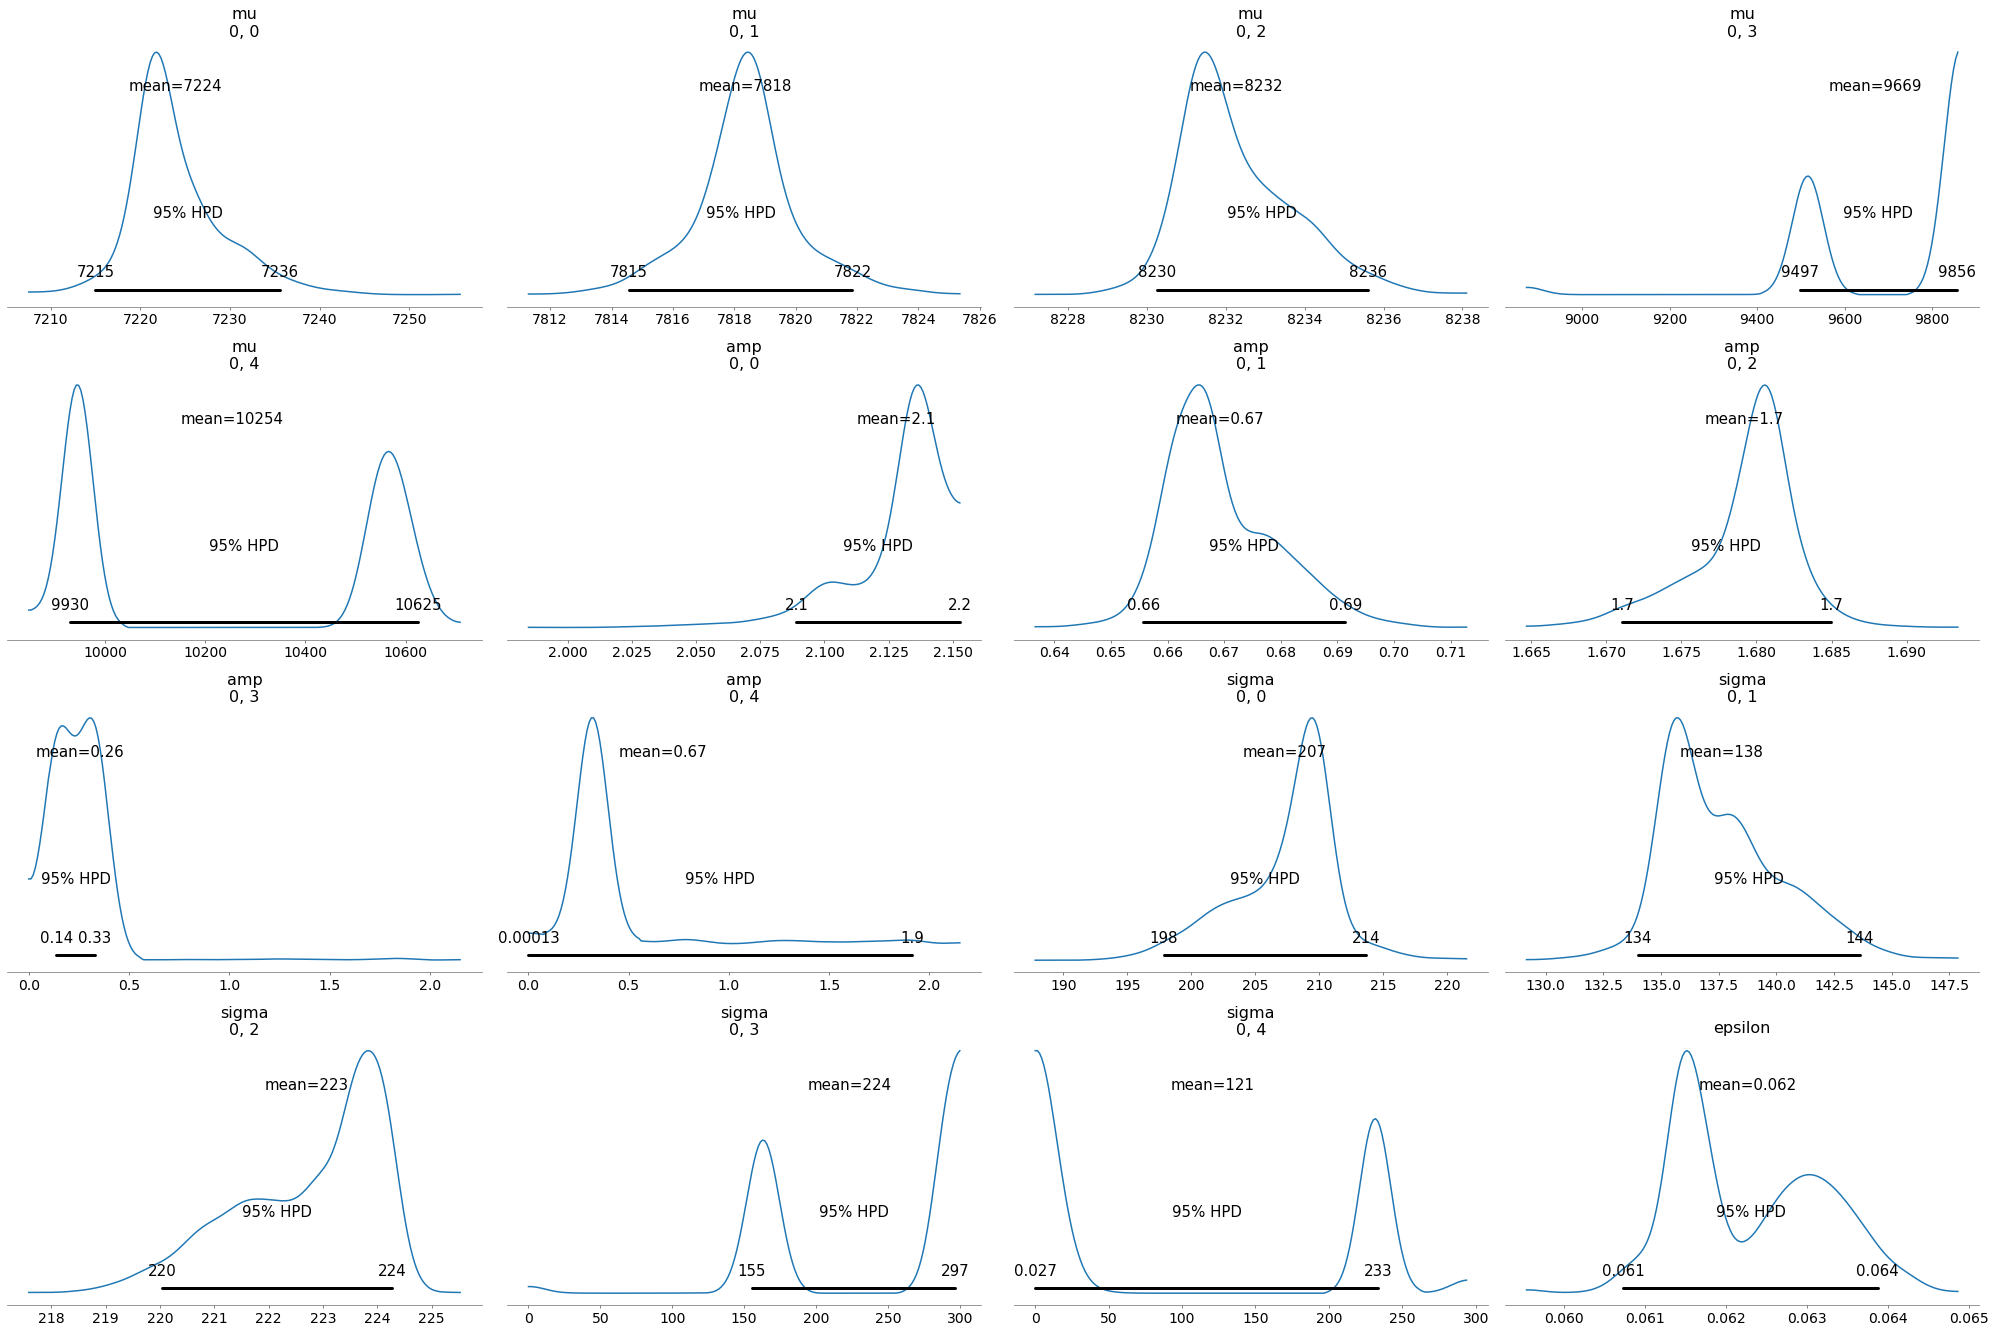

In [22]:
az.plot_posterior(traces[n_trace], ['mu', 'amp', 'sigma', 'epsilon'], credible_interval=0.95);

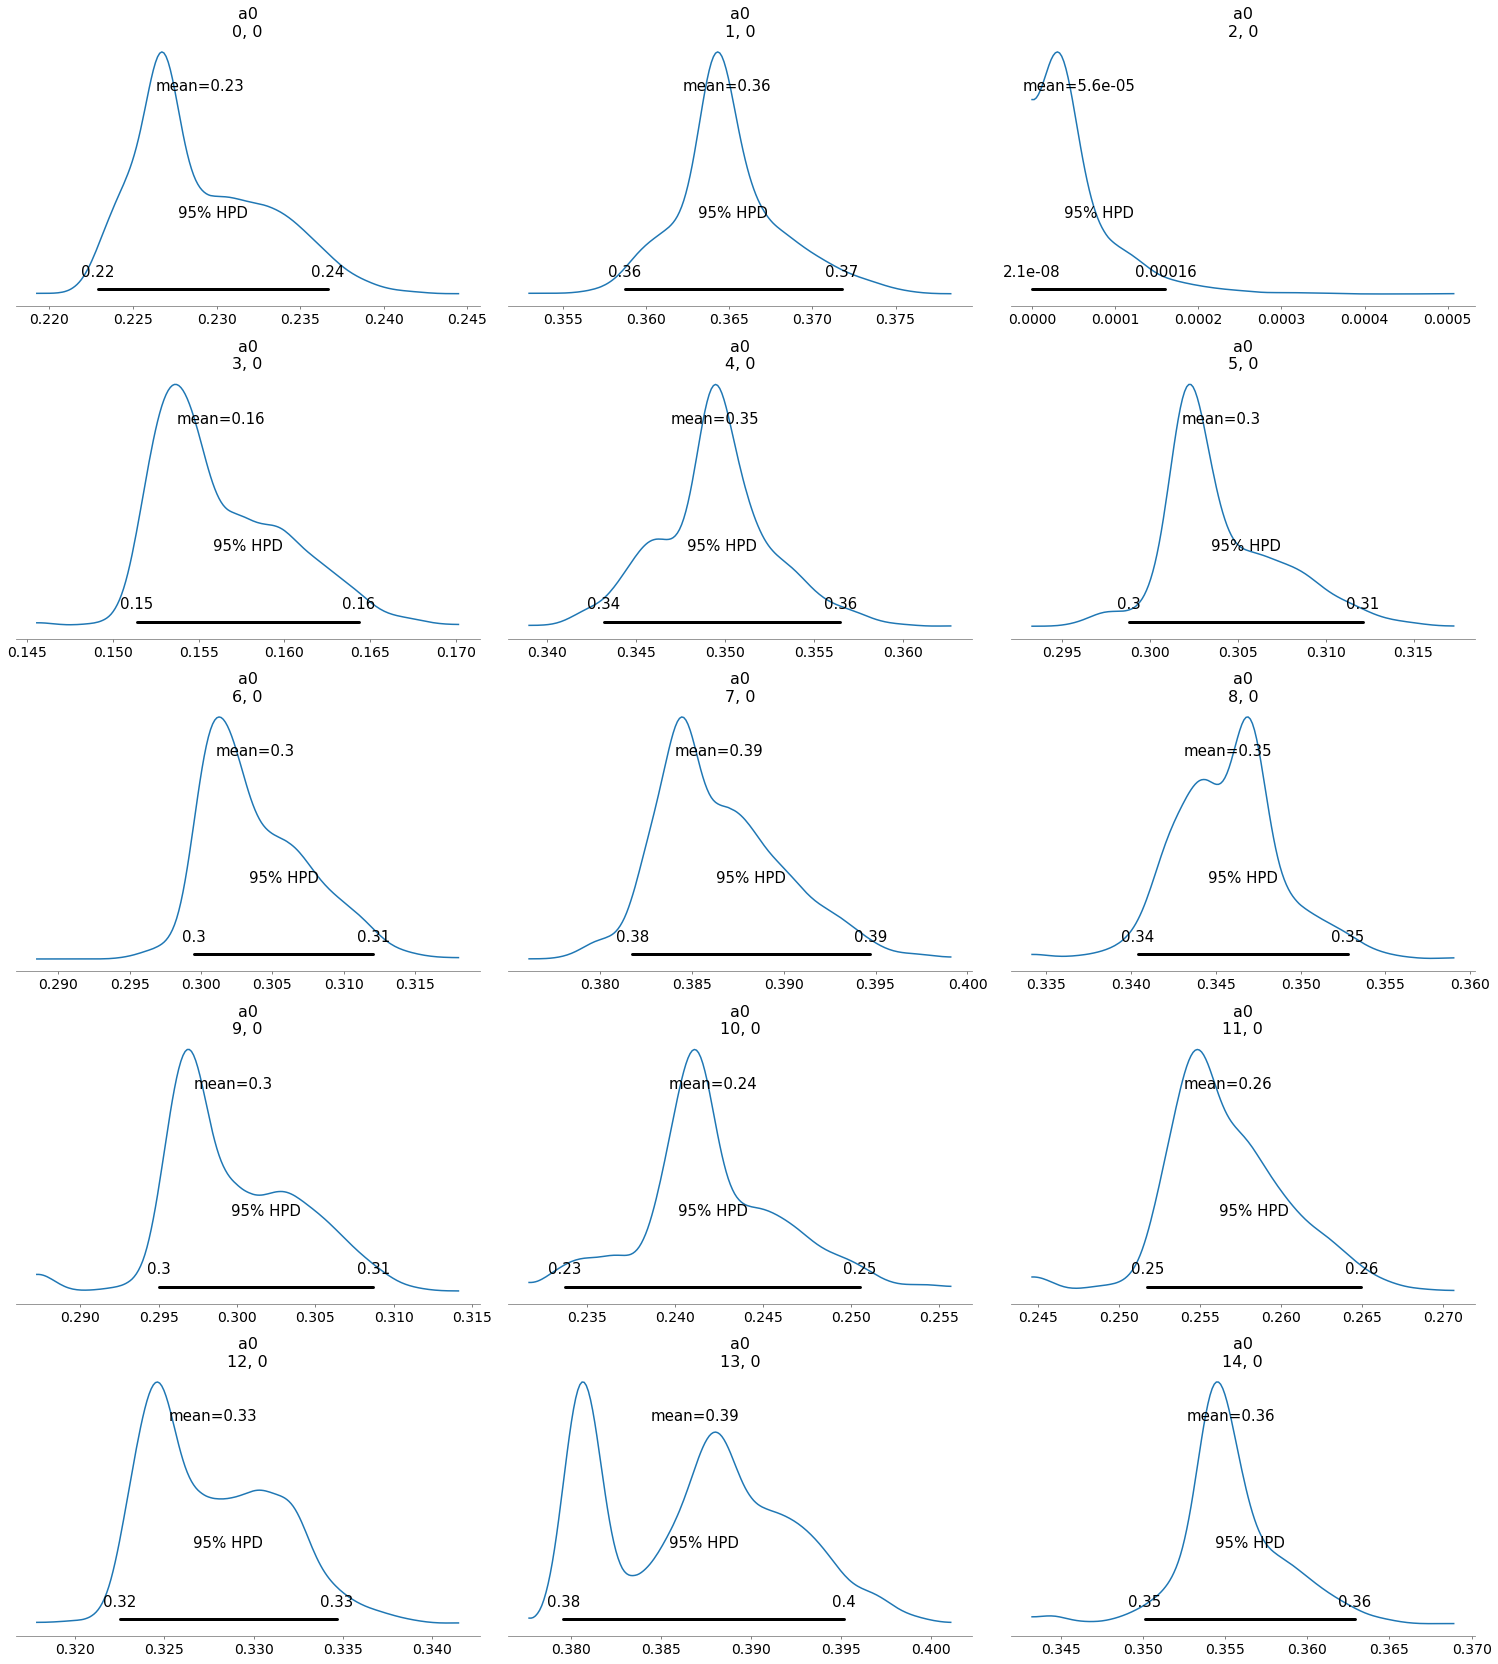

In [23]:
az.plot_posterior(traces[n_trace], ['a0'], credible_interval=0.95);